In [1]:
## First we'll need to setup our environment with the necessary imports

# Basic imports
import numpy as np 
import pandas as pd
import os
from os import path

# Viz imports
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer


from string import punctuation
import re,string,unicodedata

# Model imports
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

# Neural Net imports
import keras
from keras.layers import Dense,LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
df = pd.read_csv("Musical_instruments_reviews.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
df.shape

(10261, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [5]:
df.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

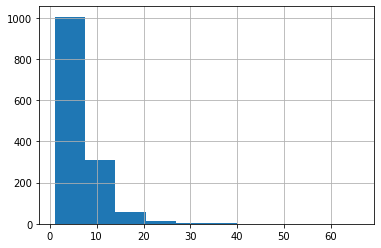

In [6]:
df.reviewerName.value_counts().hist()

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [8]:
# Create a full picture of all the relevant text associated with each review
df['full_review'] = df['reviewText'] + ' ' + df['summary']

# Create a feature that gives us a length of each review
df['review_length']  = df['full_review'].str.len()

# Drop columns we won't be using
df.drop(['reviewText', 'reviewerID', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

# Fix the naming convention for each of the remaining columns
df = df.rename(columns={"asin": "product_id", 'overall':'rating'})

# Drop rows with missing values
df = df.dropna()

df.head()

,product_id,rating,summary,full_review,review_length
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0
1,1384719342,5.0,Jake,The product does exactly as it should and is q...,549.0
2,1384719342,5.0,It Does The Job Well,The primary job of this device is to block the...,457.0
3,1384719342,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,236.0
4,1384719342,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,197.0


## Exploration and Visualization

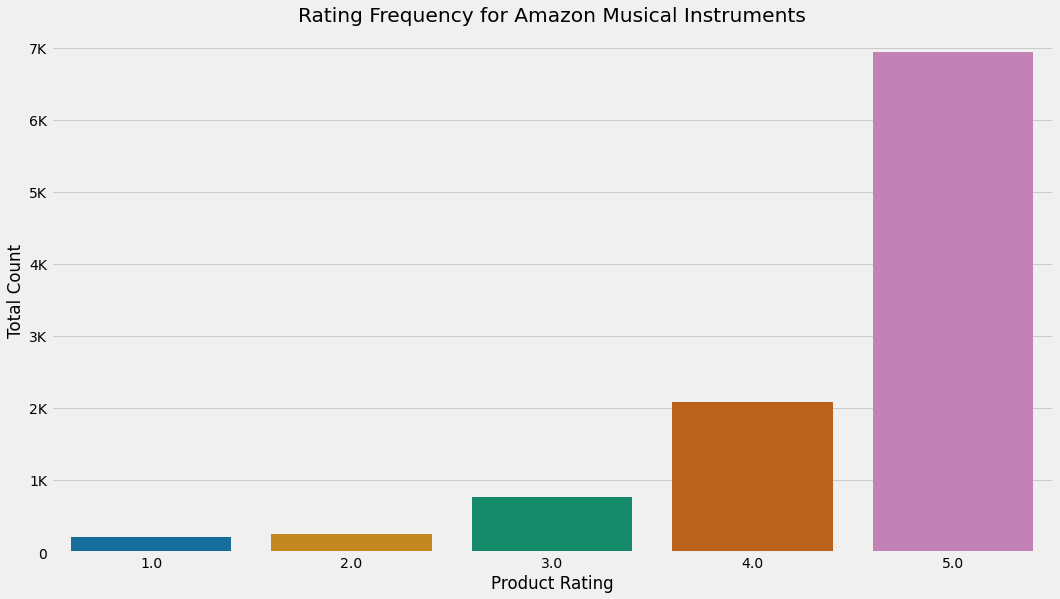

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 9))
sns.countplot(df['rating'], data=df, palette='colorblind')
plt.title('Rating Frequency for Amazon Musical Instruments')
plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000], ['0', '1K', '2K', '3K', '4K', '5K', '6K', '7K'])
plt.ylabel('Total Count')
plt.xlabel('Product Rating')
plt.show()

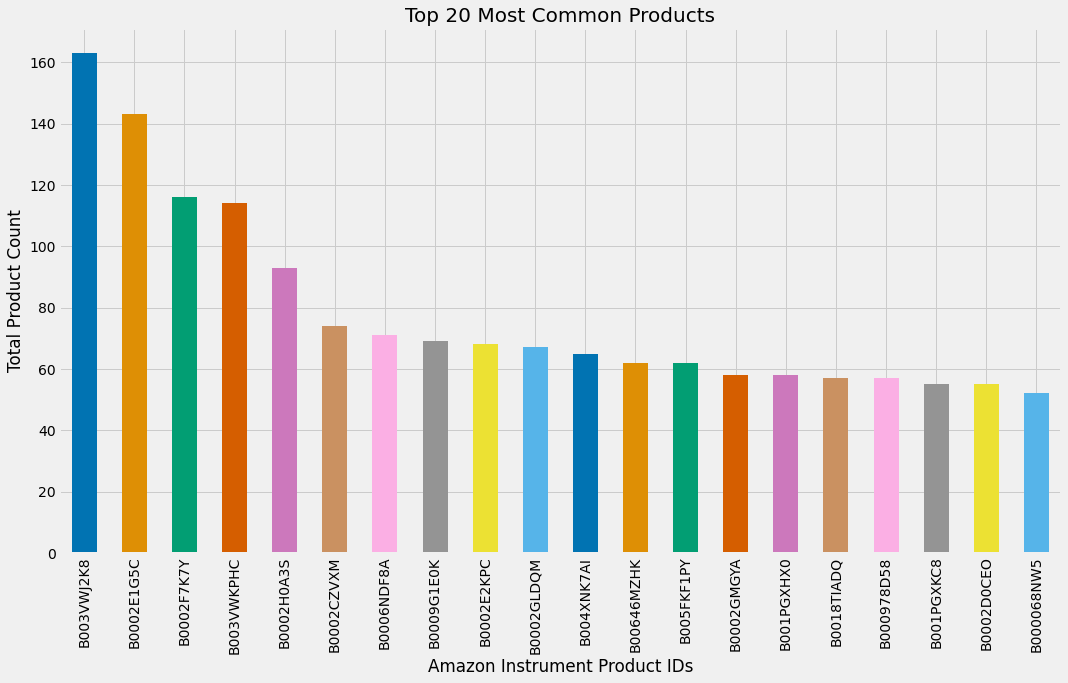

In [10]:
# Create a pandas series of the Top 20 Most Common Products
top_20 = df['product_id'].value_counts()[:20]

color_pal = sns.color_palette("colorblind")
plt.figure(figsize=(16, 9))
top_20 = df['product_id'].value_counts()[:20]
top_20.plot.bar(color=color_pal)
plt.title('Top 20 Most Common Products', fontsize = 20)
plt.xlabel('Amazon Instrument Product IDs')
plt.ylabel('Total Product Count')
plt.show()

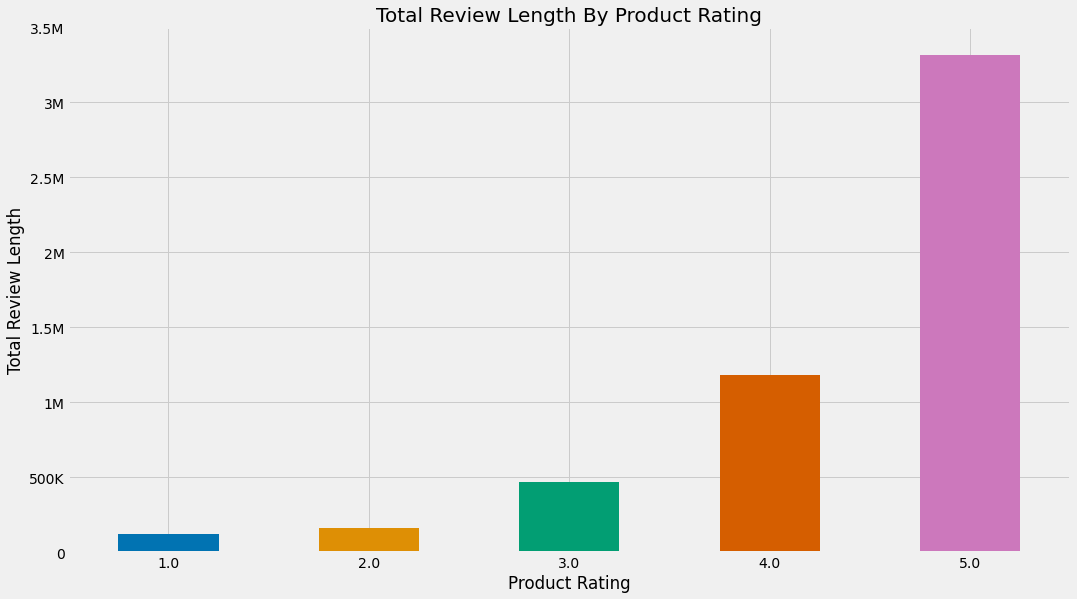

In [11]:
# 
df_review_length = df.groupby(['rating'])['review_length'].sum()

plt.figure(figsize=(16, 9))
color_pal = sns.color_palette("colorblind")

df_review_length.plot.bar(color=color_pal, rot=0)

plt.title('Total Review Length By Product Rating', fontsize = 20)
plt.xlabel('Product Rating')
plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000], ['0', '500K', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M'])
plt.ylabel('Total Review Length')

plt.show()

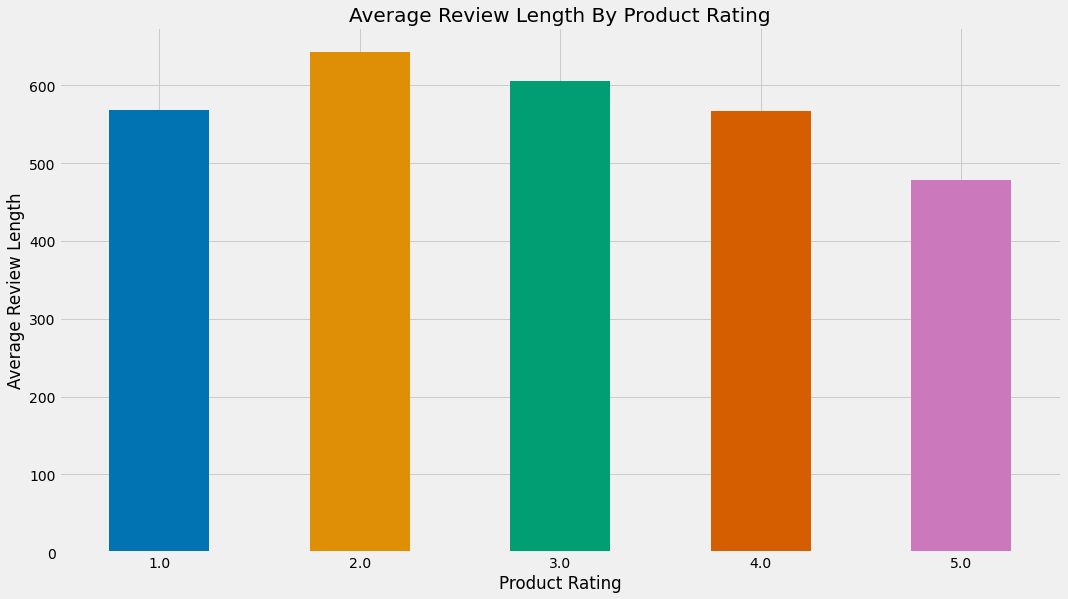

In [12]:
df_review_length = df.groupby(['rating'])['review_length'].mean()

plt.figure(figsize=(16, 9))
color_pal = sns.color_palette("colorblind")

df_review_length.plot.bar(color=color_pal, rot=0)

plt.title('Average Review Length By Product Rating', fontsize = 20)
plt.xlabel('Product Rating')
plt.ylabel('Average Review Length')

plt.show()

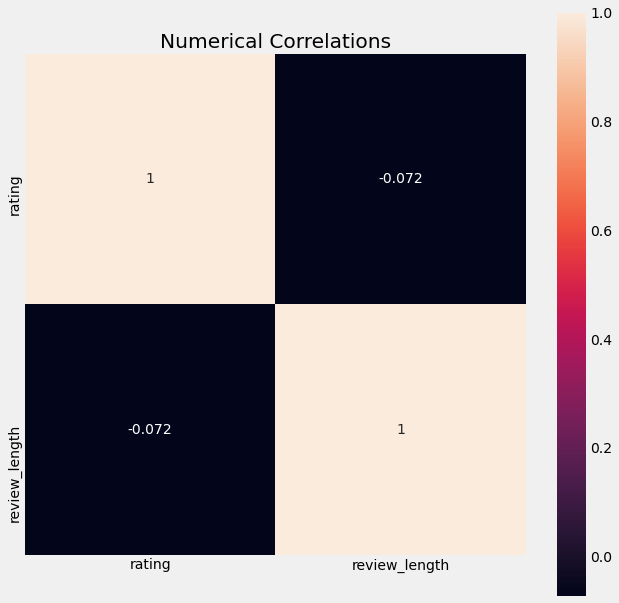

In [13]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(df.corr(), square=True, annot=True)
plt.title('Numerical Correlations')
plt.show()

In [14]:
df.head()

,product_id,rating,summary,full_review,review_length
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0
1,1384719342,5.0,Jake,The product does exactly as it should and is q...,549.0
2,1384719342,5.0,It Does The Job Well,The primary job of this device is to block the...,457.0
3,1384719342,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,236.0
4,1384719342,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,197.0


## NLP Processing and Modeling

In [15]:
# def clean(text: str) -> list:
#     'A simple function to cleanup text data'
    
#     wnl = nltk.stem.WordNetLemmatizer()
#     stopwords = nltk.corpus.stopwords.words('english')
#     text = (text.encode('ascii', 'ignore')
#              .decode('utf-8', 'ignore')
#              .lower())
#     words = re.sub(r'[^\w\s]', '', text).split() # tokenization
#     return [wnl.lemmatize(word) for word in words if word not in stopwords]

# corpus = clean(' '.join(df.full_review))

# def listToString(s):  
    
#     # initialize an empty string 
#     str1 = " " 
    
#     # return string   
#     return (str1.join(s)) 

# #w = corpus

# corpus_str = listToString(corpus)

# d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# # Read the whole text.
# #text = ham_str

# # read the mask / color image taken from
# # http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
# coloring = np.array(Image.open(path.join(d, "Amazon-logo.jpg")))
# stopwords = set(STOPWORDS)
# #stopwords.add("said")

# wc = WordCloud(background_color="white", max_words=2000, mask=coloring,
#                stopwords=stopwords, max_font_size=40, random_state=42)
# # generate word cloud
# wc.generate(corpus_str)

# # create coloring from image
# image_colors = ImageColorGenerator(coloring)

# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")
# #plt.figure()
# fig1 = plt.gcf()
# plt.show()
# plt.draw()
# fig1.savefig("amazon_nlp_word_cloud.png", bbox_inches='tight', dpi=600)

## Modeling

In [16]:
df.head()

,product_id,rating,summary,full_review,review_length
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0
1,1384719342,5.0,Jake,The product does exactly as it should and is q...,549.0
2,1384719342,5.0,It Does The Job Well,The primary job of this device is to block the...,457.0
3,1384719342,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,236.0
4,1384719342,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,197.0


In [17]:
df.rating.value_counts()

5.0    6932
4.0    2083
3.0     772
2.0     250
1.0     217
Name: rating, dtype: int64

In [18]:
# Sentiment function for creating "sentiment" feature/column
def sentiment(rating):
    if(int(rating) == 1 or int(rating) == 2 or int(rating) == 3):
        return 0
    else: 
        return 1
    
# Add a new column to the dataframe with this encoded sentiment
df['rating_sentiment'] = df.rating.apply(sentiment) 

In [19]:
df.rating_sentiment.value_counts()

1    9015
0    1239
Name: rating_sentiment, dtype: int64

In [20]:
df.sample(10)

,product_id,rating,summary,full_review,review_length,rating_sentiment
6012,B0010CZ8GS,5.0,"Well make, good looking.",It's well make and cheap compare with other pr...,221.0,1
9400,B005SUS1JO,3.0,whats more metal than metal to your strings?,while the product is everything it said it wou...,257.0,0
8161,B003VWJ2K8,5.0,great little tuner,"There are a TON of reviews here, and I don't h...",593.0,1
4087,B0009RLE5Y,5.0,My concerns were unfounded,I was concerned when I bought this that my mic...,326.0,1
2140,B0002F7K7Y,5.0,Excelente!!,como siempre esta marca con sus productos de c...,126.0,1
2842,B0002H0A3S,5.0,Great Choice,Got the 3 pack and oh what a great difference ...,828.0,1
7157,B0027M30Z6,5.0,"Great amp, especially for the price",The HoneyTone is aptly named. It has a long r...,979.0,1
2331,B0002GLDQM,5.0,Very good product,I have mi picks available and all in the same ...,153.0,1
6550,B001GH4H3W,5.0,Handy tool to keep from waking up the family,This device has been a blessing for my bass gu...,424.0,1
6465,B001EL6I8W,5.0,Great ukulele for a great price!,Great ukulele! Very light which is nice. Inton...,227.0,1


In [21]:
def basic_clean(df, col):
    '''
    This function takes in a df and a string for a column and
    returns the df with a new column named 'basic_clean' with the
    passed column text normalized.
    '''
    df['basic_clean'] = df[col].str.lower()\
                    .replace(r'[^\w\s]', '', regex=True)\
                    .str.normalize('NFKC')\
                    .str.encode('ascii', 'ignore')\
                    .str.decode('utf-8', 'ignore')
    return df

def tokenize(df, col):
    '''
    This function takes in a df and a string for a column and
    returns a df with a new column named 'clean_tokes' with the
    passed column text tokenized and in a list.
    '''
    tokenizer = nltk.tokenize.ToktokTokenizer()
    df['clean_tokes'] = df[col].apply(tokenizer.tokenize)
    return df

def stem(df, col):
    '''
    This function takes in a df and a string for a column name and
    returns a df with a new column named 'stemmed'.
    '''
    # Create porter stemmer
    ps = nltk.porter.PorterStemmer()
    
    # Stem each token from our clean_tokes Series of lists
    stems = df[col].apply(lambda row: [ps.stem(word) for word in row])
    
    # Join our cleaned, stemmed lists of words back into sentences
    df['stemmed'] = stems.str.join(' ')
    
    return df

def lemmatize(df, col):
    '''
    This function takes in a df and a string for column name and
    returns the original df with a new column called 'lemmatized'.
    '''
    # Create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Lemmatize each token from our clean_tokes Series of lists
    lemmas = df[col].apply(lambda row: [wnl.lemmatize(word) for word in row])
    
    # Join the cleaned and lemmatized tokens back into sentences
    df['lemmatized'] = lemmas.str.join(' ')
    return df

def remove_stopwords(df, col):
    '''
    This function takes in a df and a string for column name and 
    returns the df with a new column named 'clean' with stopwords removed.
    '''
    # Create stopword_list
    stopword_list = nltk.corpus.stopwords.words('english')
    stopword_list.extend('&#9;')
    
    # Split words in column
    words = df[col].str.split()
    
    # Check each word in each row of the column against stopword_list and return only those that are not in list
    filtered_words = words.apply(lambda row: [word for word in row if word not in stopword_list])
    
    # Create new column of words that have stopwords removed
    df['clean_' + col] = filtered_words.str.join(' ')
    
    return df

def prep_nlp_data(df):
    '''
    This function takes in the github repo df and
    returns the df with original columns plus cleaned
    and lemmatized content without stopwords.
    '''

    # Do basic clean on repo content
    df = basic_clean(df, 'full_review')
    
    # Tokenize clean content
    df = tokenize(df, 'basic_clean')
    
    # Stem cleaned and tokenized content
    df = stem(df, 'clean_tokes')
    
    # Lemmatize cleaned and tokenized content
    df = lemmatize(df, 'clean_tokes')
    
    # Remove stopwords from Lemmatized content
    df = remove_stopwords(df, 'lemmatized')
    
    return df

In [22]:
prep_nlp_data(df)

,product_id,rating,summary,full_review,review_length,rating_sentiment,basic_clean,clean_tokes,stemmed,lemmatized,clean_lemmatized
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0,1,not much to write about here but it does exact...,"[not, much, to, write, about, here, but, it, d...",not much to write about here but it doe exactl...,not much to write about here but it doe exactl...,much write doe exactly supposed filter pop sou...
1,1384719342,5.0,Jake,The product does exactly as it should and is q...,549.0,1,the product does exactly as it should and is q...,"[the, product, does, exactly, as, it, should, ...",the product doe exactli as it should and is qu...,the product doe exactly a it should and is qui...,product doe exactly quite affordablei realized...
2,1384719342,5.0,It Does The Job Well,The primary job of this device is to block the...,457.0,1,the primary job of this device is to block the...,"[the, primary, job, of, this, device, is, to, ...",the primari job of thi devic is to block the b...,the primary job of this device is to block the...,primary job device block breath would otherwis...
3,1384719342,5.0,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...,236.0,1,nice windscreen protects my mxl mic and preven...,"[nice, windscreen, protects, my, mxl, mic, and...",nice windscreen protect my mxl mic and prevent...,nice windscreen protects my mxl mic and preven...,nice windscreen protects mxl mic prevents pop ...
4,1384719342,5.0,No more pops when I record my vocals.,This pop filter is great. It looks and perform...,197.0,1,this pop filter is great it looks and performs...,"[this, pop, filter, is, great, it, looks, and,...",thi pop filter is great it look and perform li...,this pop filter is great it look and performs ...,pop filter great look performs like studio fil...
...,...,...,...,...,...,...,...,...,...,...,...
10256,B00JBIVXGC,5.0,Five Stars,"Great, just as expected. Thank to all. Five S...",50.0,1,great just as expected thank to all five stars,"[great, just, as, expected, thank, to, all, fi...",great just as expect thank to all five star,great just a expected thank to all five star,great expected thank five star
10257,B00JBIVXGC,5.0,"Long life, and for some players, a good econom...",I've been thinking about trying the Nanoweb st...,3088.0,1,ive been thinking about trying the nanoweb str...,"[ive, been, thinking, about, trying, the, nano...",ive been think about tri the nanoweb string fo...,ive been thinking about trying the nanoweb str...,ive thinking trying nanoweb string wa bit put ...
10258,B00JBIVXGC,4.0,Good for coated.,I have tried coated strings in the past ( incl...,636.0,1,i have tried coated strings in the past inclu...,"[i, have, tried, coated, strings, in, the, pas...",i have tri coat string in the past includ elix...,i have tried coated string in the past includi...,tried coated string past including elixir neve...
10259,B00JBIVXGC,4.0,Taylor Made,"Well, MADE by Elixir and DEVELOPED with Taylor...",1656.0,1,well made by elixir and developed with taylor ...,"[well, made, by, elixir, and, developed, with,...",well made by elixir and develop with taylor gu...,well made by elixir and developed with taylor ...,well made elixir developed taylor guitar strin...


In [23]:
df.head(1)

,product_id,rating,summary,full_review,review_length,rating_sentiment,basic_clean,clean_tokes,stemmed,lemmatized,clean_lemmatized
0,1384719342,5.0,good,"Not much to write about here, but it does exac...",273.0,1,not much to write about here but it does exact...,"[not, much, to, write, about, here, but, it, d...",not much to write about here but it doe exactl...,not much to write about here but it doe exactl...,much write doe exactly supposed filter pop sou...


In [24]:
X = df.clean_lemmatized
y = df.rating_sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8,stratify=y, random_state=19)

In [25]:
X = df.clean_lemmatized
y = df.rating_sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8,stratify=y, random_state=19)

# Create of Count Vectorize object
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

# Transform the train dataset
cv_train=cv.fit_transform(X_train)

# Transform the test dataset
cv_test=cv.transform(X_test)

print('Bag of words Train:',cv_train.shape)
print('Bag of words Test:',cv_test.shape)

Bag of words Train: (8203, 585271)
Bag of words Test: (2051, 585271)


In [26]:
# Create the TF-IDF object
tfidf=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

# Transform the train dataset
tfidf_train=tfidf.fit_transform(X_train)

# Transform the test dataset
tfidf_test=tfidf.transform(X_test)

print('TF-IDF Train:',tfidf_train.shape)
print('TF-IDF Test:',tfidf_test.shape)

TF-IDF Train: (8203, 585271)
TF-IDF Test: (2051, 585271)


In [27]:
# Create our model object
mnb = MultinomialNB()

# Fit the model to the Bag of words CountVectorizor
mnb_cv = mnb.fit(cv_train, y_train)

# Fit the model to the TF-IDF features
mnb_tfidf = mnb.fit(tfidf_train, y_train)

In [28]:
# Predicting the model for bag of words
mnb_cv_predict=mnb.predict(cv_test)

# Predicting the model for tf-idf features
mnb_tfidf_predict=mnb.predict(tfidf_test)

In [29]:
# Check the accuracy score for bag of words
mnb_cv_score=accuracy_score(y_test, mnb_cv_predict)
print("Naive Bayes Bag of words accuracy score:", mnb_cv_score)

# Check the accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
print("Naive Bayes TF-IDF accuracy score:", mnb_tfidf_score)

Naive Bayes Bag of words accuracy score: 0.878595806923452
Naive Bayes TF-IDF accuracy score: 0.878595806923452


In [30]:
mnb_cv_report = classification_report(y_test, mnb_cv_predict, target_names = ['0','1'])
print(mnb_cv_report)
mnb_tfidf_report = classification_report(y_test, mnb_tfidf_predict, target_names = ['0','1'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

           0       0.43      0.01      0.02       248
           1       0.88      1.00      0.94      1803

    accuracy                           0.88      2051
   macro avg       0.65      0.50      0.48      2051
weighted avg       0.83      0.88      0.83      2051

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.88      1.00      0.94      1803

    accuracy                           0.88      2051
   macro avg       0.44      0.50      0.47      2051
weighted avg       0.77      0.88      0.82      2051



In [31]:
model = Sequential()
model.add(Dense(units = 75 , activation = 'relu' , input_dim = cv_train.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu')) 
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                43895400  
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 43,900,746
Trainable params: 43,900,746
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(cv_train, y_train , epochs = 10)

Epoch 1/10
8203/8203 [==============================] - 196s 24ms/step - loss: 0.4040 - accuracy: 0.8783
Epoch 2/10
8203/8203 [==============================] - 187s 23ms/step - loss: 0.0246 - accuracy: 0.9888
Epoch 3/10
8203/8203 [==============================] - 187s 23ms/step - loss: 1.4426e-04 - accuracy: 1.0000
Epoch 4/10
8203/8203 [==============================] - 184s 22ms/step - loss: 9.2508e-05 - accuracy: 1.0000
Epoch 5/10
8203/8203 [==============================] - 185s 23ms/step - loss: 6.6116e-05 - accuracy: 1.0000
Epoch 6/10
8203/8203 [==============================] - 185s 23ms/step - loss: 4.9278e-05 - accuracy: 1.0000
Epoch 7/10
8203/8203 [==============================] - 184s 22ms/step - loss: 3.7835e-05 - accuracy: 1.0000
Epoch 8/10
8203/8203 [==============================] - 185s 23ms/step - loss: 2.9794e-05 - accuracy: 1.0000
Epoch 9/10
8203/8203 [==============================] - 195s 24ms/step - loss: 2.3688e-05 - accuracy: 1.0000
Epoch 10/10
8203/8203 [====

In [34]:
loss, accuracy = model.evaluate(cv_train, y_train, verbose = 0)
print("Train loss:", loss)
print("Train accuracy:", accuracy)

Train loss: 1.7287686315863664e-05
Train accuracy: 1.0


In [35]:
loss, accuracy = model.evaluate(cv_test, y_test, verbose = 0)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.9431349185159973
Test accuracy: 0.8800585269927979


In [36]:
X = df.clean_lemmatized
y = df.rating_sentiment

In [37]:
tf=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))
X=tf.fit_transform(X)

In [38]:
X_train, X_test, y_train ,y_test = train_test_split(X, y, test_size = 0.2 , random_state = 0)

mnb_model=MultinomialNB()

mnb_model = mnb_model.fit(X_train, y_train)

predictions = mnb_model.predict(X_test)

score=accuracy_score(y_test, predictions)

print("Score: ", score)

Score:  0.8781082398829839


In [39]:
mnb_bow_report = classification_report(y_test, predictions)
print(mnb_bow_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.88      1.00      0.94      1801

    accuracy                           0.88      2051
   macro avg       0.44      0.50      0.47      2051
weighted avg       0.77      0.88      0.82      2051



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
model = Sequential()
model.add(Dense(units = 75 , activation = 'relu' , input_dim = cv_train.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu')) 
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [41]:
model.fit(cv_train, y_train , epochs = 10)

Epoch 1/10
8203/8203 [==============================] - 193s 24ms/step - loss: 0.4156 - accuracy: 0.8766
Epoch 2/10
8203/8203 [==============================] - 187s 23ms/step - loss: 0.0305 - accuracy: 0.9821
Epoch 3/10
8203/8203 [==============================] - 188s 23ms/step - loss: 0.0028 - accuracy: 0.9998
Epoch 4/10
8203/8203 [==============================] - 187s 23ms/step - loss: 5.7270e-04 - accuracy: 0.9999
Epoch 5/10
8203/8203 [==============================] - 187s 23ms/step - loss: 5.2640e-04 - accuracy: 0.9999
Epoch 6/10
8203/8203 [==============================] - 187s 23ms/step - loss: 5.1351e-04 - accuracy: 0.9999
Epoch 7/10
8203/8203 [==============================] - 189s 23ms/step - loss: 5.1053e-04 - accuracy: 0.9999
Epoch 8/10
8203/8203 [==============================] - 188s 23ms/step - loss: 4.8359e-04 - accuracy: 0.9999
Epoch 9/10
8203/8203 [==============================] - 189s 23ms/step - loss: 5.1032e-04 - accuracy: 0.9999
Epoch 10/10
8203/8203 [========

In [42]:
loss, accuracy = model.evaluate(cv_test, y_test, verbose = 0)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.7609480187580214
Test accuracy: 0.8732325434684753
